# Negation scope - withOUT bag of words
## Loading dataset

In [11]:
from datetime import datetime
from negation_scope_common import create_semi_dataset, create_vectorizer, create_columns_names
from negation_scope_common import create_features_list, save_to_csv
from utils import get_datasets


def create_dataset(dataset, sufix):
    ouput_name = '{}.csv'.format(dataset[:-4])
    print('{} START Creating semi dataset {}'.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S"), dataset))
    X_train, X_test = create_semi_dataset(dataset)
    vect_lemma = create_vectorizer(X_train)
    column_names = create_columns_names(X_train, vect_lemma, add_bow=False)
    print('{} START Creating features list {}'.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S"), dataset))
    X_train_features_list = create_features_list(X_train, vect_lemma, add_bow=False)
    X_test_features_list = create_features_list(X_test, vect_lemma, add_bow=False)
    print('{} START Save csv {}'.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S"), dataset))
    save_to_csv(ouput_name + sufix + '-train', column_names, X_train_features_list)
    save_to_csv(ouput_name + sufix + '-test', column_names, X_test_features_list)
    print('{} END Save csv {}'.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S"), dataset))


# for dataset in get_datasets():
#     create_dataset(dataset, '-sco')

In [12]:
create_dataset('dataset/all/merged.xml', '-sco')

2017-05-09 01:11:15 START Creating semi dataset dataset/all/merged.xml


2017-05-09 01:11:17 START Creating features list dataset/all/merged.xml


2017-05-09 01:14:04 START Save csv dataset/all/merged.xml


2017-05-09 01:14:16 END Save csv dataset/all/merged.xml


## Training

In [1]:
%%time
from negation_common import load_dataset

df_train, df_test, df2_train, df2_test = load_dataset('dataset/all/merged.csv', 
                                                      '-sco', 
                                                      ['token', 'lemma', 'POS', 'is_in_scope', 'negator_pos'])

CPU times: user 2.45 s, sys: 356 ms, total: 2.81 s
Wall time: 3.67 s


In [5]:
%%time
# Import Library of Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


# model = MultinomialNB()
# model = GaussianNB()
# model = BernoulliNB()
# model = SVC()
model = RandomForestClassifier(n_estimators=200, bootstrap=False, criterion='entropy')

# Train the model using the training sets 
model.fit(df2_train, df_train.is_in_scope)

CPU times: user 16.7 s, sys: 489 ms, total: 17.2 s
Wall time: 20.1 s


## Metrics

In [6]:
from utils import print_score_for

y_true, y_pred = print_score_for(model, df2_test, y_true=df_test.is_in_scope)

Accuracy: 0.9436238306253077
Precision: 0.8532388663967612
Recall: 0.7292387543252595
F1 score: 0.7863805970149254
             precision    recall  f1-score   support

          0       0.96      0.98      0.97      6968
          1       0.85      0.73      0.79      1156

avg / total       0.94      0.94      0.94      8124



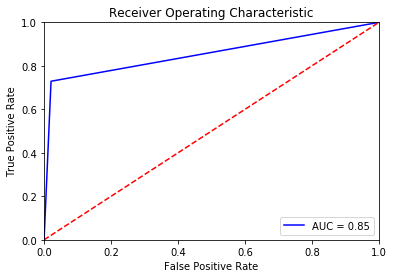

In [7]:
from utils import show_roc_curve

fig = show_roc_curve(y_true, y_pred)
fig.savefig('images/sco-all-main.svg')
fig.show()

dataset/beletria/merged.xml


Accuracy: 0.9448051948051948
Precision: 0.8548387096774194
Recall: 0.6794871794871795
F1 score: 0.7571428571428572
             precision    recall  f1-score   support

          0       0.95      0.98      0.97      1614
          1       0.85      0.68      0.76       234

avg / total       0.94      0.94      0.94      1848



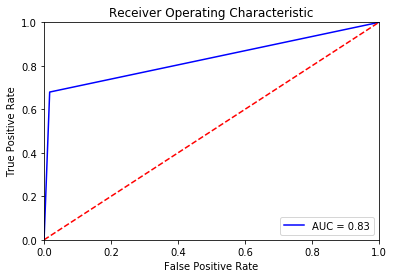

dataset/recenzie/merged.xml


Accuracy: 0.9242105263157895
Precision: 0.7102272727272727
Recall: 0.6868131868131868
F1 score: 0.6983240223463687
             precision    recall  f1-score   support

          0       0.95      0.96      0.96      1243
          1       0.71      0.69      0.70       182

avg / total       0.92      0.92      0.92      1425



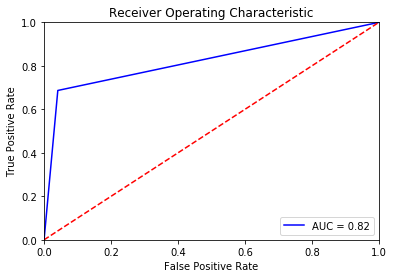

dataset/snk/merged.xml


Accuracy: 0.9656370656370656
Precision: 0.8725099601593626
Recall: 0.7934782608695652
F1 score: 0.8311195445920304
             precision    recall  f1-score   support

          0       0.98      0.99      0.98      2314
          1       0.87      0.79      0.83       276

avg / total       0.96      0.97      0.96      2590



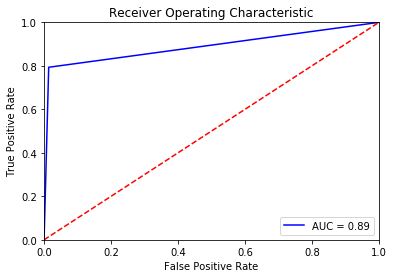

dataset/sport/merged.xml


Accuracy: 0.8890510948905109
Precision: 0.9209621993127147
Recall: 0.5665961945031712
F1 score: 0.7015706806282721
             precision    recall  f1-score   support

          0       0.88      0.99      0.93      1582
          1       0.92      0.57      0.70       473

avg / total       0.89      0.89      0.88      2055



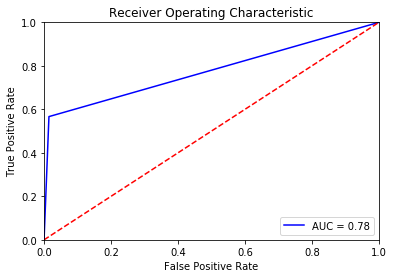

dataset/vlastne_mario/merged.xml
Accuracy: 0.90625
Precision: 0.8095238095238095
Recall: 0.5483870967741935
F1 score: 0.6538461538461537
             precision    recall  f1-score   support

          0       0.92      0.98      0.95       161
          1       0.81      0.55      0.65        31

avg / total       0.90      0.91      0.90       192



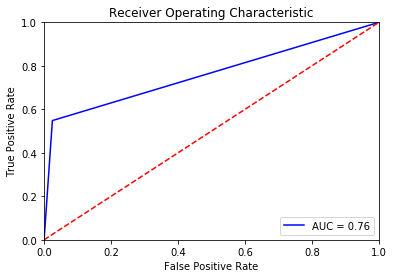

In [6]:
import pickle
from negation_common import load_dataset
from utils import get_datasets, print_score_for, show_roc_curve

with open('model-RandomForest-sco.pkl', 'rb') as f:
    model = pickle.load(f)

sufix = '-sco'
for dataset in get_datasets():
    print('============================================')
    print(dataset)
    df_train, df_test, df2_train, df2_test = load_dataset(dataset, sufix, 
                                                          ['token', 'lemma', 'POS', 'is_in_scope', 'negator_pos'])
    y_true, y_pred = print_score_for(model, df2_test, y_true=df_test.is_in_scope)
    plot = show_roc_curve(y_true, y_pred)
    img_name = dataset.split('/')[1]
    plot.savefig('images/sco-RandomForest-{}.svg'.format(img_name), transparent=True)
    plot.show()

In [5]:
dataset = 'dataset/snk/merged.xml'
sufix = '-sco'
ouput_name = '{}.csv'.format(dataset[:-4])
X_train, X_test = create_semi_dataset(dataset)
vect_lemma = create_vectorizer(X_train)
column_names = create_columns_names(X_train, vect_lemma, add_bow=False)
# X_train_features_list = create_features_list(X_train, vect_lemma, add_bow=False)
X_test_features_list = create_features_list(X_test, vect_lemma, add_bow=False)
# save_to_csv(ouput_name + sufix + '-train', column_names, X_train_features_list)
# save_to_csv(ouput_name + sufix + '-test', column_names, X_test_features_list)

In [5]:
#
# Save model
#

import pickle
with open('model-RandomForest-sco.pkl', 'wb') as fout:
    pickle.dump(model, fout)

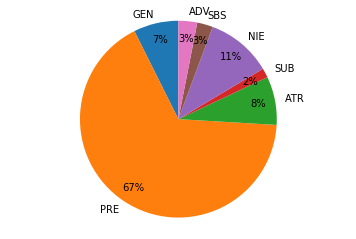

In [15]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'GEN', 'PRE', 'ATR', 'SUB', 'NIE', 'SBS', 'ADV'
sizes = [91, 823, 98, 19, 133, 32, 38]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.f%%', startangle=90, labeldistance=1.1, pctdistance=0.83)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig('images/pie.svg')

plt.show()

In [5]:
# Grid Search for Algorithm Tuning
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

param_grid = {"n_estimators": [60, 100, 200],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# param_grid = {"max_depth": [3, None],
#               "max_features": [1, 3, 10],
#               "min_samples_split": [2, 3, 5, 10],
#               "min_samples_leaf": [1, 3, 10],
#               "bootstrap": [True, False],
#               "criterion": ["gini", "entropy"]}

# create and fit a ridge regression model, testing each alpha
model = RandomForestClassifier()
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=metrics.make_scorer(metrics.f1_score))
grid.fit(df2_train, df_train.is_in_scope)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_params_)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'bootstrap': [True, False], 'criterion': ['gini', 'entropy'], 'n_estimators': [60, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score), verbose=0)
0.760180504822
{'bootstrap': False, 'criterion': 'entropy', 'n_estimators': 200}
